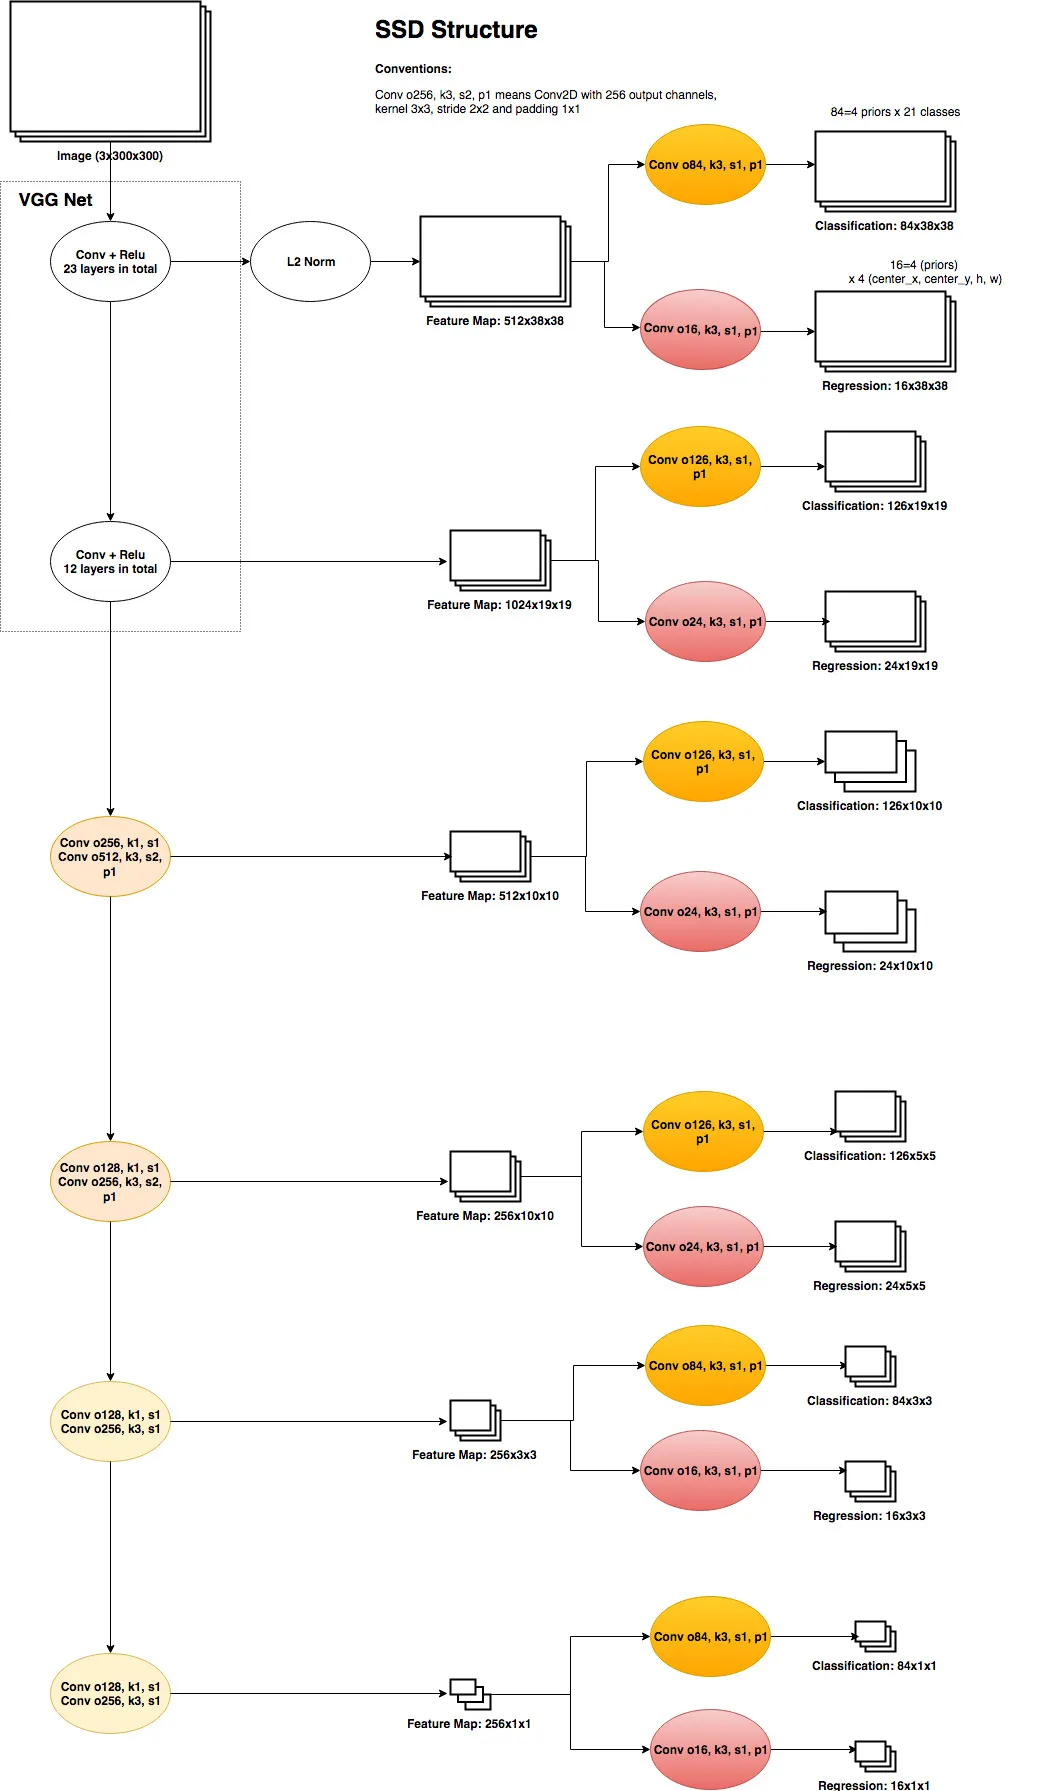

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.io import read_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tqdm.notebook import trange, tqdm

C:\Users\SriramAppusamy\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### VGG 16 architecture

In [2]:
class VGG16(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        # input size => output size
        self.layers = nn.Sequential(
            # 3,300,300 => 64,300,300
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            # 64,300,300 => 64,300,300
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            # 64,300,300 => 64,150,150
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64,150,150 => 128,150,150
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # 128,150,150 => 128,150,150
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # 128,150,150 => 128,75,75
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 128,75,75 => 256,75,75
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # 256,75,75 => 256,75,75
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # 256,75,75 => 256,75,75
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # 256,75,75 => 256,38,38
            nn.AdaptiveMaxPool2d(output_size=38),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # 256,38,38 => 512,38,38
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,38,38 => 512,38,38
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,38,38 => 512,38,38
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,38,38 => 512,19,19
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 512,38,38 => 512,10,10
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,10,10 => 512,10,10
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,10,10 => 512,10,10
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,10,10 => 512,10,10
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.fc = nn.Sequential(nn.Linear(512*9*9, 4096), nn.ReLU(), nn.Linear(4096, 4096), nn.Linear(4096, num_classes))
        

    def forward(self, x):
        convolved = self.layers(x)
        bs,_,h,w = convolved.shape
        convolved = convolved.view(bs, -1)
        return self.fc(convolved)


### Things to know aboubt size/shape of the image

In [3]:
# Normally image read as (Height, Width, Channels) in cv2, plt & PIL
# plt.imread("D:/Learning/ImageClassification/id_cards/2.jpg").shape
# Output: (181, 278, 3)
# In torch, it is read as (Channels, Height, Width) - channels in the first dimension
# Output: (3, 181, 278)

In [4]:
plt.imread("D:/Learning/ImageClassification/id_cards/2.jpg").shape

(181, 278, 3)

In [5]:
read_image("D:/Learning/ImageClassification/id_cards/2.jpg").shape

torch.Size([3, 181, 278])

### Transform input image to the network

In [6]:
transforms = T.Compose([T.Resize(size= (300,300)),
                       T.ToTensor()])

In [7]:
transforms

Compose(
    Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### Dataset for classification

In [8]:
ds = ImageFolder("D:/Learning/ImageClassification/",
                transform = transforms)

In [9]:
ds

Dataset ImageFolder
    Number of datapoints: 26
    Root location: D:/Learning/ImageClassification/
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [10]:
ds.classes

['id_cards', 'road_signs']

In [11]:
num_classes = len(ds.classes)
num_classes

2

### VGG network creation

In [12]:
vgg = VGG16(num_classes)

In [13]:
vgg

VGG16(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): AdaptiveMaxPool2d(output_size=38)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU()
    (19): C

### Create dataloader

In [14]:
dataloader = DataLoader(ds, batch_size=2, shuffle=True)

### Loss function & optimizer setup

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr = 1e-03)

### Training loop

In [24]:
for epoch in trange(10):
    t = tqdm(dataloader, total = len(dataloader))
    for xb, yb in t:
        logits = vgg(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        t.set_postfix(loss = loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [320]:
xb.shape

torch.Size([2, 3, 300, 300])

In [321]:
yb.shape

torch.Size([2])

In [322]:
vgg(xb)

tensor([[-0.0044,  0.0033],
        [-0.0044,  0.0033]], grad_fn=<AddmmBackward0>)

In [71]:
with torch.no_grad():
    logits = vgg.layers(x)

In [72]:
logits.shape

torch.Size([1, 512, 9, 9])

In [73]:
x = torch.rand(1,3,300,300)

In [74]:
with torch.no_grad():
    logits = vgg.layers(x)

In [75]:
logits.shape

torch.Size([1, 512, 9, 9])

In [76]:
len(vgg.layers)

31

In [27]:
x = torch.rand(1,3,300,300)

In [28]:
vgg.layers[:15](x).shape

torch.Size([1, 256, 75, 75])

In [25]:
vgg.layers[:22]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): AdaptiveMaxPool2d(output_size=38)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=

In [85]:
with torch.no_grad():
    fm = vgg.layers[:23](x)

In [86]:
fm.shape

torch.Size([1, 512, 38, 38])

In [90]:
with torch.no_grad():
    fm = vgg.layers[:30](x)

In [91]:
fm.shape

torch.Size([1, 512, 19, 19])

In [197]:
with torch.no_grad():
    fm = vgg.layers[:10](x)

In [198]:
fm.shape

torch.Size([1, 512, 38, 38])

In [180]:
vgg.layers[:9]

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d

In [214]:
m = torch.rand(1,128,19,19)

In [213]:
nn.AdaptiveMaxPool2d(output_size=38)(m).shape

torch.Size([1, 128, 38, 38])

In [215]:
nn.MaxPool2d(kernel_size=2, stride=2)(m).shape

torch.Size([1, 128, 9, 9])

In [22]:
im = torch.rand(1, 3, 18, 18)

In [23]:
im.shape

torch.Size([1, 3, 18, 18])

In [19]:
c1 = nn.Conv2d(in_channels=3, out_channels= 3, kernel_size=3, stride=3)

In [25]:
o1 = c1(im)
o1.shape

torch.Size([1, 3, 6, 6])

In [26]:
m1 = nn.MaxPool2d(kernel_size=2, stride=2)

In [28]:
m1(o1).shape

torch.Size([1, 3, 3, 3])

In [92]:
input_img_size = (300, 300)

feature_map_size = (38,38)

scales = [(1,1), (1, 2), (2,1)]

aspect_ratio = (16, 16)

#38 * 38 feature map dimension
Xmin = 3.165
Ymin = 5.064
Xmax = 18.19
Ymax = 25.32

def generate_anchor_boxes(input_img_size, feature_map_size, scales):
  anchors = []
  for i in range(feature_map_size[0]):
    for j in range(feature_map_size[1]):
      for scale in scales:
        #width = (Xmax- Xmin)
        #height = (Ymax- Ymin)
        width = input_img_size[0] * scale[0] / aspect_ratio[0]
        height = input_img_size[1] * scale[1] / aspect_ratio[1]
        anchors.append((width, height))
  
  return torch.tensor(anchors)

boxes = generate_anchor_boxes(input_img_size, feature_map_size, scales)
print(boxes.shape)

torch.Size([4332, 2])


In [ ]:
0  to 0
1 to 38

In [97]:
0 to 38

126.3157894736842

In [102]:
300/38

7.894736842105263

In [ ]:
16,32,48

In [101]:
300/16

18.75

In [103]:
boxes * 7.894736842105263


tensor([[148.0263, 148.0263],
        [148.0263, 296.0526],
        [296.0526, 148.0263],
        ...,
        [148.0263, 148.0263],
        [148.0263, 296.0526],
        [296.0526, 148.0263]])

In [ ]:
0.5

In [14]:
ag = AnchorGenerator()

In [15]:
ag

AnchorGenerator()

In [24]:
img_list = torchvision.models.detection.image_list.ImageList(
    torch.LongTensor(1,3,300,300).random_(0,256), [(300,300)]
)

In [25]:
fm = torch.FloatTensor(1,512,38,38)

In [39]:
anchors = ag(img_list, fm)

In [40]:
anc = anchors[0]

In [172]:
anc.shape

torch.Size([12996, 4])

In [41]:
anc

tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        ...,
        [ 214.,  168.,  304.,  350.],
        [ 168.,   78.,  350.,  440.],
        [  78., -103.,  440.,  621.]])

In [42]:
anc.shape

torch.Size([12996, 4])

In [47]:
anc[:9]

tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        [ -64.,  -64.,   64.,   64.],
        [-128., -128.,  128.,  128.],
        [-256., -256.,  256.,  256.],
        [ -45.,  -91.,   45.,   91.],
        [ -91., -181.,   91.,  181.],
        [-181., -362.,  181.,  362.]])

In [48]:
anc[9:18]

tensor([[ -84.,  -45.,   98.,   45.],
        [-174.,  -91.,  188.,   91.],
        [-355., -181.,  369.,  181.],
        [ -57.,  -64.,   71.,   64.],
        [-121., -128.,  135.,  128.],
        [-249., -256.,  263.,  256.],
        [ -38.,  -91.,   52.,   91.],
        [ -84., -181.,   98.,  181.],
        [-174., -362.,  188.,  362.]])

In [73]:
anc[18:27]

tensor([[ -77.,  -45.,  105.,   45.],
        [-167.,  -91.,  195.,   91.],
        [-348., -181.,  376.,  181.],
        [ -50.,  -64.,   78.,   64.],
        [-114., -128.,  142.,  128.],
        [-242., -256.,  270.,  256.],
        [ -31.,  -91.,   59.,   91.],
        [ -77., -181.,  105.,  181.],
        [-167., -362.,  195.,  362.]])

In [91]:
h = torch.sqrt(torch.tensor(0.5))
w = 1/h
w,h

(tensor(1.4142), tensor(0.7071))

In [95]:
scales = (128, 256, 512)
aspect_ratios = (0.5, 1, 2.0)

In [97]:
scales = torch.as_tensor(scales)
aspect_ratios = torch.as_tensor(aspect_ratios)
h_ratios = torch.sqrt(aspect_ratios)
w_ratios = 1 / h_ratios

In [98]:
h_ratios

tensor([0.7071, 1.0000, 1.4142])

In [99]:
w_ratios

tensor([1.4142, 1.0000, 0.7071])

In [100]:
ws = (w_ratios[:, None] * scales[None, :]).view(-1)
hs = (h_ratios[:, None] * scales[None, :]).view(-1)

In [106]:
w_ratios[:,None]

tensor([[1.4142],
        [1.0000],
        [0.7071]])

In [103]:
(w_ratios[:, None] * scales[None, :])

tensor([[181.0193, 362.0387, 724.0773],
        [128.0000, 256.0000, 512.0000],
        [ 90.5097, 181.0193, 362.0387]])

In [101]:
ws

tensor([181.0193, 362.0387, 724.0773, 128.0000, 256.0000, 512.0000,  90.5097,
        181.0193, 362.0387])

In [102]:
hs

tensor([ 90.5097, 181.0193, 362.0387, 128.0000, 256.0000, 512.0000, 181.0193,
        362.0387, 724.0773])

In [107]:
base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2

In [108]:
base_anchors

tensor([[ -90.5097,  -45.2548,   90.5097,   45.2548],
        [-181.0193,  -90.5097,  181.0193,   90.5097],
        [-362.0387, -181.0193,  362.0387,  181.0193],
        [ -64.0000,  -64.0000,   64.0000,   64.0000],
        [-128.0000, -128.0000,  128.0000,  128.0000],
        [-256.0000, -256.0000,  256.0000,  256.0000],
        [ -45.2548,  -90.5097,   45.2548,   90.5097],
        [ -90.5097, -181.0193,   90.5097,  181.0193],
        [-181.0193, -362.0387,  181.0193,  362.0387]])

In [155]:
shifts_x = torch.arange(0, 38, dtype=torch.int32) * 7
shifts_y = torch.arange(0, 38, dtype=torch.int32) * 7

In [156]:
shifts_x

tensor([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,  91,
         98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189,
        196, 203, 210, 217, 224, 231, 238, 245, 252, 259], dtype=torch.int32)

In [157]:
shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")

In [158]:
shift_y

tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [  7,   7,   7,  ...,   7,   7,   7],
        [ 14,  14,  14,  ...,  14,  14,  14],
        ...,
        [245, 245, 245,  ..., 245, 245, 245],
        [252, 252, 252,  ..., 252, 252, 252],
        [259, 259, 259,  ..., 259, 259, 259]], dtype=torch.int32)

In [159]:
shift_x

tensor([[  0,   7,  14,  ..., 245, 252, 259],
        [  0,   7,  14,  ..., 245, 252, 259],
        [  0,   7,  14,  ..., 245, 252, 259],
        ...,
        [  0,   7,  14,  ..., 245, 252, 259],
        [  0,   7,  14,  ..., 245, 252, 259],
        [  0,   7,  14,  ..., 245, 252, 259]], dtype=torch.int32)

In [160]:
shift_x = shift_x.reshape(-1)
shift_y = shift_y.reshape(-1)

In [161]:
shift_x

tensor([  0,   7,  14,  ..., 245, 252, 259], dtype=torch.int32)

In [162]:
shift_y

tensor([  0,   0,   0,  ..., 259, 259, 259], dtype=torch.int32)

In [163]:
shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

In [168]:
shifts

tensor([[  0,   0,   0,   0],
        [  7,   0,   7,   0],
        [ 14,   0,  14,   0],
        ...,
        [245, 259, 245, 259],
        [252, 259, 252, 259],
        [259, 259, 259, 259]], dtype=torch.int32)

In [165]:
(shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4)

tensor([[ -90.5097,  -45.2548,   90.5097,   45.2548],
        [-181.0193,  -90.5097,  181.0193,   90.5097],
        [-362.0387, -181.0193,  362.0387,  181.0193],
        ...,
        [ 213.7452,  168.4903,  304.2548,  349.5097],
        [ 168.4903,   77.9807,  349.5097,  440.0193],
        [  77.9807, -103.0387,  440.0193,  621.0387]])

In [166]:
base_anchors

tensor([[ -90.5097,  -45.2548,   90.5097,   45.2548],
        [-181.0193,  -90.5097,  181.0193,   90.5097],
        [-362.0387, -181.0193,  362.0387,  181.0193],
        [ -64.0000,  -64.0000,   64.0000,   64.0000],
        [-128.0000, -128.0000,  128.0000,  128.0000],
        [-256.0000, -256.0000,  256.0000,  256.0000],
        [ -45.2548,  -90.5097,   45.2548,   90.5097],
        [ -90.5097, -181.0193,   90.5097,  181.0193],
        [-181.0193, -362.0387,  181.0193,  362.0387]])

In [154]:
torch.empty((), dtype=torch.int64).fill_(300 // 38)

tensor(7)

In [138]:
shifts.view(-1,1,4)[:9]

tensor([[[0, 0, 0, 0]],

        [[1, 0, 1, 0]],

        [[2, 0, 2, 0]],

        [[3, 0, 3, 0]],

        [[4, 0, 4, 0]],

        [[5, 0, 5, 0]],

        [[6, 0, 6, 0]],

        [[7, 0, 7, 0]],

        [[8, 0, 8, 0]]], dtype=torch.int32)

In [127]:
base_anchors.view(1, -1, 4).shape

torch.Size([1, 9, 4])

In [194]:
import math
ab = torch.zeros(38,38,9,4)
conv_pixel = 300//38 #7
for i in range(0,38):
    for j in range(0,38):
        c = 0 
        for ar in [0.5, 1.0, 2.0]:
            h = math.sqrt(ar)
            w = 1/h
            for s in [128,256,512]:
                x = i * conv_pixel
                y = j * conv_pixel

                xmin = x - (w*s)/2
                ymin = y - (h*s)/2
                xmax = x + (w*s)/2
                ymax = y + (h*s)/2

                ab[i, j, c,:] = torch.tensor([xmin,ymin,xmax,ymax])
                c+=1

                

In [200]:
ab_1 = ab.reshape(-1,4).round()

In [202]:
ab_1

tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        ...,
        [ 214.,  168.,  304.,  350.],
        [ 168.,   78.,  350.,  440.],
        [  78., -103.,  440.,  621.]])

In [201]:
anc

tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        ...,
        [ 214.,  168.,  304.,  350.],
        [ 168.,   78.,  350.,  440.],
        [  78., -103.,  440.,  621.]])

In [92]:
def get_wh(grid_x, grid_y,scale):
    return w*grid_x*scale, h*grid_y*scale

In [93]:
get_wh(0,0, 128)

(tensor(0.), tensor(0.))

In [30]:
import torch
import torch.nn.functional as F

In [32]:
x = torch.randn(1,10)
y = torch.randn(1,10)

In [33]:
F.pairwise_distance(x,y)

tensor([4.8773])

In [38]:
torch.sqrt(torch.pow(x-y,2).sum(1))

tensor([4.8773])

In [39]:
A = torch.randn(5,10)

In [41]:
A

tensor([[-0.0627,  0.5950,  0.3845,  1.6422,  0.1179, -1.3788, -1.1463, -1.0293,
         -0.0604,  0.9399],
        [-0.1435, -1.7081,  0.3526, -0.4470,  0.8615,  0.4092,  0.4622, -0.0761,
          0.5253,  0.9463],
        [ 2.0087, -0.0654, -0.4034, -1.6031,  1.0958,  1.1097, -0.6933,  0.0844,
         -1.0593,  0.5276],
        [ 1.2366, -0.3625, -0.2286,  0.1321, -0.0357,  0.8986, -0.6477,  0.5905,
          0.3428,  1.0823],
        [ 0.4927, -0.7441, -0.3805, -0.5419, -1.1625,  0.8787, -0.3039,  1.4155,
         -0.7065, -0.3458]])

In [52]:
def get_pairwise_distance(A):
    # shape of A = Number of images x n-dim
    bs, ndim = A.shape
    return torch.sqrt(torch.sum(torch.pow((A - A.view(bs,1,ndim)),2),2))

In [54]:
dist = get_pairwise_distance(A)

In [55]:
dist

tensor([[0.0000, 4.1552, 5.0638, 3.6779, 4.7906],
        [4.1552, 0.0000, 3.7190, 2.6760, 3.4923],
        [5.0638, 3.7190, 0.0000, 2.7536, 3.4423],
        [3.6779, 2.6760, 2.7536, 0.0000, 2.5270],
        [4.7906, 3.4923, 3.4423, 2.5270, 0.0000]])

In [63]:
bs, ndim = A.shape

In [64]:
dist[list(range(bs)), list(range(bs))] = torch.inf

In [65]:
dist

tensor([[   inf, 4.1552, 5.0638, 3.6779, 4.7906],
        [4.1552,    inf, 3.7190, 2.6760, 3.4923],
        [5.0638, 3.7190,    inf, 2.7536, 3.4423],
        [3.6779, 2.6760, 2.7536,    inf, 2.5270],
        [4.7906, 3.4923, 3.4423, 2.5270,    inf]])

In [67]:
dist.argmin(dim=1)

tensor([3, 3, 3, 4, 3])

In [70]:
dist[list(range(bs)), dist.argmin(dim=1)]

tensor([3.6779, 2.6760, 2.7536, 2.5270, 2.5270])

In [ ]:
bs, ndim = A.shape

dist[list(range(bs)), list(range(bs))] = torch.inf

dist

dist.argmin(dim=1)

dist[list(range(bs)), dist.argmin(dim=1)]